# Redes Neuronales - TP2
## Ej 4
- a - Implemente una red con aprendizaje Backpropagation que aprenda la siguiente
función:

$$f (x , y , z)=sin(x)+cos(y)+z$$

donde: x e y ∊ [0,2 π] y z ∊[−1,1]. Para ello construya un conjunto de datos de entrenamiento y un conjunto de evaluación. Muestre la evolución del error  e
entrenamiento y de evaluación en función de las épocas de entrenamiento.

- b - Estudie la evolución de los errores durante el entrenamiento de una red con una capa oculta de 30 neuronas cuando el conjunto de entrenamiento contiene 40 muestras. ¿Que ocurre si el minibatch tiene tamaño 40? ¿Y si tiene tamaño 1?

Acá la consigna lo lo explicita pero hay que aplicar algo de minibatch al lagoritmo de aprendizaje.

Robando de un post de stackExchange:

batch gradient descent you process the entire training set in one iteration. Whereas, in a mini-batch gradient descent you process a small subset of the training set in each iteration.

Also compare stochastic gradient descent, where you process a single example from the training set in each iteration.

Another way to look at it: they are all examples of the same approach to gradient descent with a batch size of m and a training set of size n. For stochastic gradient descent, m=1. For batch gradient descent, m = n. For mini-batch, m=b and b < n, typically b is small compared to n.

Mini-batch adds the question of determining the right size for b, but finding the right b may greatly improve your results.




Dicho todo esto, la idea es tomar el set de datos y generar batches de entrenamiento. Es otro loop for y una partición de los datos de entrada. hay 2 hiperparams -> la # de minibatches y la # de veces que hacemos el proceso. Para mantener la cantidad de muestras balanceadas, solo se le pueden mostrar 1 vez por batch de minibatch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Vamos a generar las muestras de la función. Voy a barrer X, Y de 0 a 2pi para Z=+-1

In [2]:
x = np.linspace(0,1,num=200)*2*np.pi
y = x # hasta ahora tenemos los ejes
z = [-1,1]
f = []
tripletas_xyz = []

for k in z:
    for i in x:
        for j in y:
            tripletas_xyz.append([i,j,k])


# este es el dataset entero, es gigante.

# -> lo pasamos a matriz

dataset = np.asmatrix(tripletas_xyz) # listo.

# no lo shuffleo acá, es lo va a hacer el entrenador
# voy a generar el f

f = np.sin(dataset[:,0])+np.cos(dataset[:,1])+dataset[:,2]




Ahora toca shufflear las filas y hacer dataset de entrenamiento y de testeo. Por comodidad lo hago con sklearn, el resto si será a mano. Como tengo 80mil registros, y quiero batches de números enteros, voy a separar esto en una proporción 70% 30%, que me parece razonable. Luego, los minibatches serán de números como 1,10,100,1000,2000,4000.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(  dataset, f, train_size = 56000, random_state=0)

In [4]:
class perceptron_multicapa:
    def __init__(self, capas, dim_entrada):
        self.capas = capas
        self.dim_entrada = dim_entrada
        self.lista_matrices = []
        self.lr = None
        entrada_anterior = dim_entrada
        for num_perceptrones in capas:
            matriz_pesos = np.random.uniform(-2, 2, size=(num_perceptrones, entrada_anterior + 1)) # inicialización más amplia
            self.lista_matrices.append(matriz_pesos)
            entrada_anterior = num_perceptrones

    def funcion_activacion(self, x):
        return 1 / (1 + np.exp(-x))

    def derivada_activacion(self, a):
        return a * (1 - a)

    def forward(self, x):
        a = x
        activaciones = [a] # todos los x de la red cuando se propaga para adelante - es el zs pasado por la función de activación
        zs = []# todos los h de la red cuando se propaga para adelante
        for W in self.lista_matrices:
            a_b = np.concatenate(([1], a))
            z = np.dot(W, a_b)
            zs.append(z)
            a = self.funcion_activacion(z)
            activaciones.append(a)
        return activaciones, zs

    def predecir(self, X):
        salidas = []
        for x in X:
            a = x
            for W in self.lista_matrices:
                a = np.concatenate(([1], a))
                a = self.funcion_activacion(np.dot(W, a))
            salidas.append(a.reshape(-1))  # garantiza que sea vector 1D
        return np.array(salidas).reshape(len(X), -1)

    def predecir_hard(self, X):
        salidas = self.predecir(X)
        # Si la salida es entre 0 y 1 (sigmoide), umbral en 0.5
        return (salidas >= 0.5).astype(int)

    def entrenar(self, X, Y, lr=1.0, epochs=100):
        self.lr = lr
        n_samples = X.shape[0]
        self.error_por_epoch = []
        for epoch in range(epochs):
            grad_acum = [np.zeros_like(W) for W in self.lista_matrices]
            for i in range(n_samples):
                x = X[i]
                y = Y[i]
                activaciones, zs = self.forward(x) # tomo los h y x del paso foward
                deltas = [None] * len(self.lista_matrices) # lugar para guardar los deltas
                a_out = activaciones[-1] # la activavión de la salida es la última
                deltas[-1] = (a_out - y) * self.derivada_activacion(a_out) # el último delta es el de la salida, y se calcula como la salida deseada - la actual por la derivada de la func de act.
                for l in range(len(self.lista_matrices)-2, -1, -1): # acá propagamos desde la salida para aras
                    W_next = self.lista_matrices[l+1][:,1:]
                    delta_next = deltas[l+1]
                    a_l = activaciones[l+1]
                    deltas[l] = np.dot(W_next.T, delta_next) * self.derivada_activacion(a_l)
                for l in range(len(self.lista_matrices)):
                    a_prev = np.concatenate(([1], activaciones[l]))
                    grad_acum[l] += np.outer(deltas[l], a_prev)
            for l in range(len(self.lista_matrices)):
                self.lista_matrices[l] -= self.lr * grad_acum[l] / n_samples
            if epoch % 100 == 0 or epoch == epochs-1:
                pred = self.predecir(X)
                loss = np.mean((pred - Y) ** 2) # acá se va guardando el ECM para luego visualizarlo, pero se hace cada tanto, no los miles de puntos.
                self.error_por_epoch.append(loss)

    def minibatch_training(self, X, Y, tamanio, veces, lr=0.1, epochs=100, X_val=None, Y_val=None, eval_every=1, verbose=False):
        """
        Minibatch training wrapper.
        - X, Y: training data (ndarray)
        - tamanio: tamaño del minibatch (int)
        - veces: número de pasadas (epochs sobre el dataset, int)
        - lr, epochs: parámetros pasados a `entrenar` para cada minibatch
        - X_val, Y_val: si se pasan, se calcula ECM sobre validación cada `eval_every` batches
        - eval_every: frecuencia en batches para evaluar en validación (>=1)
        - verbose: si True imprime progreso resumido
        """
        # asegurar arrays numpy en caso de recibir matrices
        X = np.asarray(X)
        Y = np.asarray(Y)
        if X_val is not None and Y_val is not None:
            X_val = np.asarray(X_val)
            Y_val = np.asarray(Y_val)

        n_samples = X.shape[0]
        self.train_error_progress = []
        self.val_error_progress = []
        total_batches_per_pass = int(np.ceil(n_samples / float(tamanio)))
        for pass_idx in range(veces): # iteramos todas las veces pedidas
            indices = np.random.permutation(n_samples) # hacemos la permutacion para obtener indices randomizados
            X_shuffled = X[indices] # hacemos shuffling
            Y_shuffled = Y[indices]
            for b_idx, start in enumerate(range(0, n_samples, tamanio)):# toma de a batches de "tamanio"
                end = min(start + tamanio, n_samples)
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]
                # Entrenar sobre este minibatch (actualiza pesos acumulativamente)
                self.entrenar(X_batch, Y_batch, lr=lr, epochs=epochs)
                # Calcular ECM sobre el minibatch (rápido) y guardar progreso
                pred_batch = self.predecir(X_batch)
                batch_loss = float(np.mean((pred_batch - Y_batch) ** 2))
                self.train_error_progress.append(batch_loss)
                # Evaluación en conjunto de validación si fue provisto y corresponde por frecuencia
                if X_val is not None and Y_val is not None and ((b_idx % eval_every) == 0):
                    pred_val = self.predecir(X_val)
                    val_loss = float(np.mean((pred_val - Y_val) ** 2))
                    self.val_error_progress.append(val_loss)
                # Mensaje resumido de progreso
                if verbose and (b_idx % max(1, total_batches_per_pass//10) == 0):
                    msg = f"pass {pass_idx+1}/{veces} batch {b_idx+1}/{total_batches_per_pass} train_loss={batch_loss:.6f}"
                    if X_val is not None and Y_val is not None and ((b_idx % eval_every) == 0):
                        msg += f" val_loss={val_loss:.6f}"
                    print(msg)
        # devolver los historiales por conveniencia
        return {'train': self.train_error_progress, 'val': self.val_error_progress}

X_train shape = (56000, 3) y_train shape = (56000, 1)
X_test shape = (24000, 3) y_test shape = (24000, 1)
pass 1/10 batch 1/1400 train_loss=0.332727 val_loss=0.309758
pass 1/10 batch 141/1400 train_loss=0.212909
pass 1/10 batch 281/1400 train_loss=0.015151
pass 1/10 batch 421/1400 train_loss=0.009715
pass 1/10 batch 561/1400 train_loss=0.010719
pass 1/10 batch 701/1400 train_loss=0.009684 val_loss=0.008384
pass 1/10 batch 841/1400 train_loss=0.008119
pass 1/10 batch 981/1400 train_loss=0.007784
pass 1/10 batch 1121/1400 train_loss=0.007090
pass 1/10 batch 1261/1400 train_loss=0.007408
pass 2/10 batch 1/1400 train_loss=0.005614 val_loss=0.006148
pass 2/10 batch 141/1400 train_loss=0.003592
pass 2/10 batch 281/1400 train_loss=0.004242
pass 2/10 batch 421/1400 train_loss=0.004341
pass 2/10 batch 561/1400 train_loss=0.005790
pass 2/10 batch 701/1400 train_loss=0.003870 val_loss=0.004946
pass 2/10 batch 841/1400 train_loss=0.002841
pass 2/10 batch 981/1400 train_loss=0.003126
pass 2/10 batc

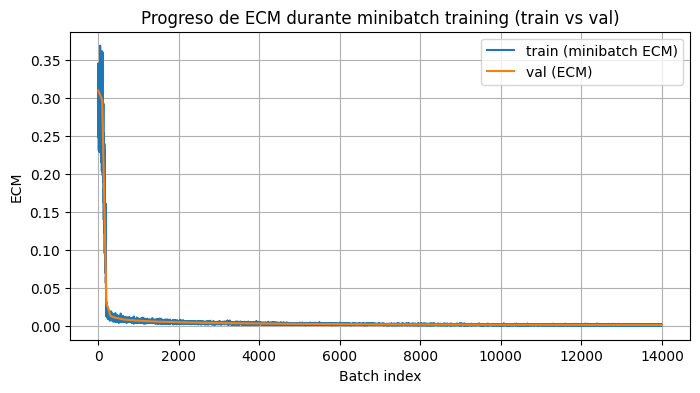

In [5]:
# --- Entrenamiento para la función f(x,y,z) usando X_train / y_train ---
# Convertir a ndarray y asegurar formas correctas (X: n x 3, y: n x 1)
X_train_arr = np.asarray(X_train, dtype=float)
y_train_arr = np.asarray(y_train, dtype=float).reshape(-1, 1)
X_test_arr = np.asarray(X_test, dtype=float)
y_test_arr = np.asarray(y_test, dtype=float).reshape(-1, 1)

print('X_train shape =', X_train_arr.shape, 'y_train shape =', y_train_arr.shape)
print('X_test shape =', X_test_arr.shape, 'y_test shape =', y_test_arr.shape)

# hay que ajustar la salida para que esté entre 0 y 1, no -3 y 3
y_train_arr = (y_train_arr + 3) / 6
y_test_arr = (y_test_arr + 3) / 6

# Crear un modelo para 3 entradas (ejemplo: 30 neuronas ocultas)
model_f = perceptron_multicapa(capas=[30, 1], dim_entrada=3)

# Entrenamiento con minibatches: tamanio de batch = 40 (configurable)
# Pasamos X_test/y_test para evaluar progreso en validación, verbose para ver avance resumido
hist = model_f.minibatch_training(X_train_arr, y_train_arr, tamanio=40, veces=10, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=100, verbose=True)

print('Entrenamiento de model_f completado.')
print('Últimos 5 train losses:', hist['train'][-5:])
print('Últimos 5 val losses:', hist['val'][-5:])

# Graficar progreso (train y validation)
plt.figure(figsize=(8,4))
x_train = np.arange(len(hist['train']))
# mapear val a indices aproximados a lo largo del eje de train para visual comparativa
if len(hist['val'])>0:
    x_val = np.linspace(0, len(hist['train'])-1, len(hist['val']))
    plt.plot(x_train, hist['train'], label='train (minibatch ECM)')
    plt.plot(x_val, hist['val'], label='val (ECM)')
else:
    plt.plot(x_train, hist['train'], label='train (minibatch ECM)')
plt.xlabel('Batch index')
plt.ylabel('ECM')
plt.title('Progreso de ECM durante minibatch training (train vs val)')
plt.legend()
plt.grid(True)
plt.show()



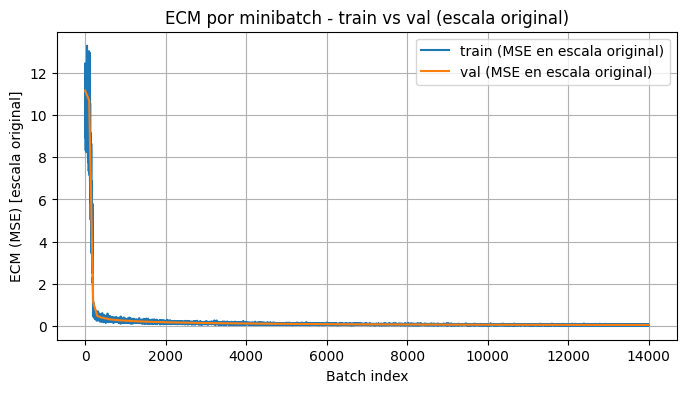

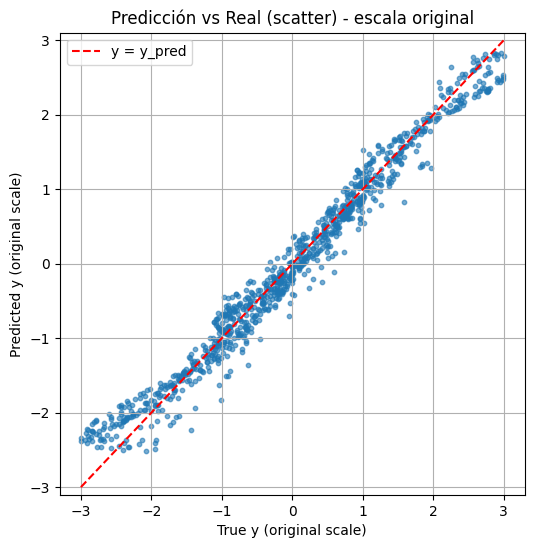

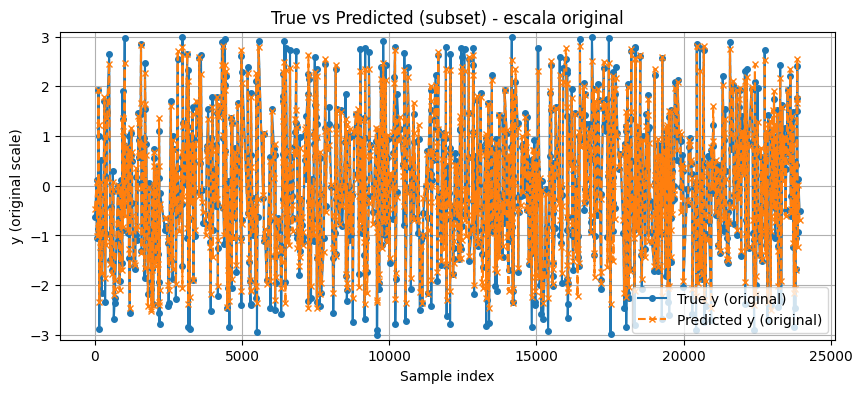

In [6]:
# Gráficos de progreso y comparación predicción vs real
# Helpers de escala (lineal entre espacio original y [0,1])
# Si cambias la transformación, actualizá estas funciones.
def scale_to_01(y):
    """Escala y (vector) del rango original [-3,3] a [0,1]."""
    y = np.asarray(y).reshape(-1)
    return (y + 3.0) / 6.0


def inverse_scale(y01):
    """Vuelve de [0,1] al rango original [-3,3]."""
    y01 = np.asarray(y01).reshape(-1)
    return y01 * 6.0 - 3.0


def plot_train_val(hist, titulo='ECM - train vs val'):
    """Plotea la historia de ECM. Hist contiene ECM calculados sobre targets escalados [0,1].
    Para mostrar en la escala original se multiplica la MSE por el factor de escala^2
    (si y_orig = a * y_scaled + b, entonces MSE_orig = a^2 * MSE_scaled).
    """
    plt.figure(figsize=(8,4))
    train = np.array(hist.get('train', []))
    val = np.array(hist.get('val', []))
    # factor para pasar MSE de escala [0,1] a original [-3,3]: a = 6 -> a^2 = 36
    factor = 6.0 ** 2
    train_orig = train * factor
    val_orig = val * factor
    x_train = np.arange(len(train))
    plt.plot(x_train, train_orig, label='train (MSE en escala original)')
    if val.size > 0:
        x_val = np.linspace(0, len(train)-1, len(val)) if len(train)>0 else np.arange(len(val))
        plt.plot(x_val, val_orig, label='val (MSE en escala original)')
    plt.xlabel('Batch index')
    plt.ylabel('ECM (MSE) [escala original]')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_pred_vs_true(X, Y, model, n_samples=500, random_seed=0):
    """Muestra dos gráficos en la escala original ([-3,3]):
    - scatter: pred vs true (línea y=x)
    - series: valores reales vs predicciones para un subconjunto de índices
    Asume que Y recibido está en la misma escala que se usó para entrenar (es decir, [0,1]).
    """
    X_arr = np.asarray(X)
    Y_arr = np.asarray(Y).reshape(-1)
    preds = model.predecir(X_arr).reshape(-1)

    # Convertir ambas series a escala original
    Y_un = inverse_scale(Y_arr)
    preds_un = inverse_scale(preds)

    N = len(Y_un)
    if N == 0:
        print('No hay muestras para graficar')
        return
    rng = np.random.default_rng(random_seed)
    if n_samples is None or n_samples >= N:
        idx = np.arange(N)
    else:
        idx = rng.choice(N, size=n_samples, replace=False)

    # scatter pred vs true (en escala original)
    plt.figure(figsize=(6,6))
    plt.scatter(Y_un[idx], preds_un[idx], alpha=0.6, s=10)
    mn = min(Y_un[idx].min(), preds_un[idx].min())
    mx = max(Y_un[idx].max(), preds_un[idx].max())
    plt.plot([mn, mx], [mn, mx], 'r--', label='y = y_pred')
    plt.xlabel('True y (original scale)')
    plt.ylabel('Predicted y (original scale)')
    plt.title('Predicción vs Real (scatter) - escala original')
    plt.legend()
    plt.grid(True)
    plt.ylim(-3.1, 3.1)
    plt.show()

    # series plot for same indices sorted
    idx_sorted = np.sort(idx)
    plt.figure(figsize=(10,4))
    plt.plot(idx_sorted, Y_un[idx_sorted], 'o-', label='True y (original)', markersize=4)
    plt.plot(idx_sorted, preds_un[idx_sorted], 'x--', label='Predicted y (original)', markersize=4)
    plt.xlabel('Sample index')
    plt.ylabel('y (original scale)')
    plt.title('True vs Predicted (subset) - escala original')
    plt.legend()
    plt.grid(True)
    plt.ylim(-3.1, 3.1)
    plt.show()


def show_prediction_for_xyz(xyz, model):
    """Recibe xyz = [x,y,z] y muestra la predicción del modelo en la escala original junto al valor real."""
    arr = np.asarray(xyz, dtype=float).reshape(1, -1)
    pred_scaled = model.predecir(arr).reshape(-1)[0]
    pred_orig = float(inverse_scale(pred_scaled))
    real = float(np.sin(xyz[0]) + np.cos(xyz[1]) + xyz[2])
    print(f'Entrada (x,y,z): {xyz}')
    print(f'Predicción (escala original): {pred_orig:.6f}')
    print(f'Valor real (escala original): {real:.6f}')
    return pred_orig


# Uso: trazamos train/val si existe el historial 'hist' retornado por minibatch_training
try:
    plot_train_val(hist, 'ECM por minibatch - train vs val (escala original)')
except NameError:
    print('Variable hist no encontrada. Ejecutá la celda de entrenamiento antes de graficar.')

# Uso: comparar pred/true en test set (se asume que y_test_arr está escalado a [0,1])
try:
    plot_pred_vs_true(X_test_arr, y_test_arr, model_f, n_samples=1000)
except NameError:
    print('Asegurate de haber entrenado model_f y de tener X_test_arr / y_test_arr en memoria.')

# Ejemplo: pedir predicción para una muestra concreta (descomentar y editar si querés probar)
# ejemplo_xyz = [0.1, 1.2, -1]
# show_prediction_for_xyz(ejemplo_xyz, model_f)


--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---
pass 1/280 batch 1/56 train_loss=0.240618 val_loss=0.239537
pass 1/280 batch 6/56 train_loss=0.136683
pass 1/280 batch 11/56 train_loss=0.050067
pass 1/280 batch 16/56 train_loss=0.049026
pass 1/280 batch 21/56 train_loss=0.045392
pass 1/280 batch 26/56 train_loss=0.040658
pass 1/280 batch 31/56 train_loss=0.039118
pass 1/280 batch 36/56 train_loss=0.038170
pass 1/280 batch 41/56 train_loss=0.036701
pass 1/280 batch 46/56 train_loss=0.036926
pass 1/280 batch 51/56 train_loss=0.032716 val_loss=0.035209
pass 1/280 batch 56/56 train_loss=0.031697
pass 2/280 batch 1/56 train_loss=0.033007 val_loss=0.033779
pass 2/280 batch 6/56 train_loss=0.031659
pass 2/280 batch 11/56 train_loss=0.033951
pass 2/280 batch 16/56 train_loss=0.029424
pass 2/280 batch 21/56 train_loss=0.029934
pass 2/280 batch 26/56 train_loss=0.030673
pass 2/280 batch 31/56 train_loss=0.026820
pass 2/280 batch 36/56 train_loss=0.027708
pass 2/280 batch 41/56 trai

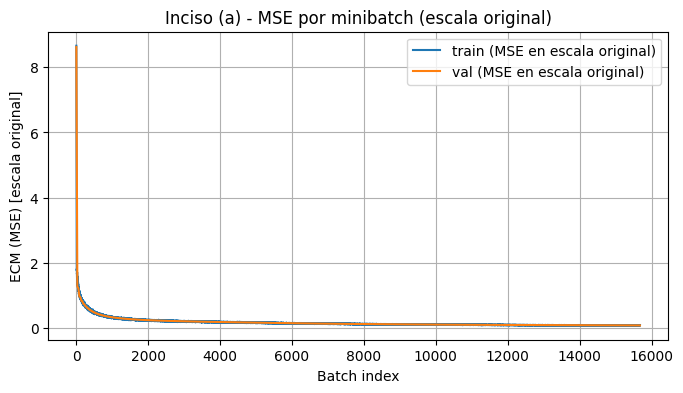

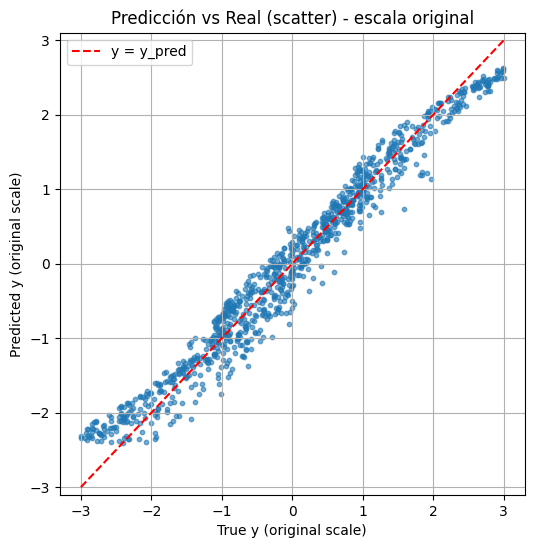

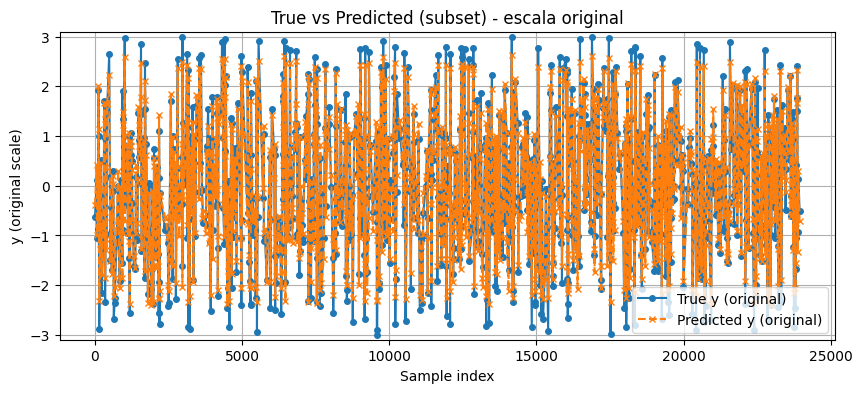


Ejemplo:
Entrada (x,y,z): [0.5, 1.0, -1]
Predicción (escala original): 0.155983
Valor real (escala original): 0.019728


C:\Users\q\AppData\Local\Temp\ipykernel_17892\3400245446.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_orig = float(inverse_scale(pred_scaled))


0.15598316084555996

In [18]:
# === Experimentos: Inciso (a) y (b) ===
# - (a) Entrenar en el dataset completo y mostrar evolución de error y predicciones
# - (b) Tomar un conjunto de entrenamiento con 40 muestras y comparar minibatch size = 40 vs = 1

import time

# Comprobaciones básicas
try:
    X_train_arr
    y_train_arr
    X_test_arr
    y_test_arr
except NameError:
    raise NameError('Ejecutá antes las celdas que generan y escalan X_train_arr / y_train_arr / X_test_arr / y_test_arr')

rng = np.random.default_rng(42)

# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[30,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=1000, veces=280, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)
##





--- Inciso (b): comparar minibatch size = 40 vs = 1 (con solo 40 muestras de entrenamiento) ---
Algunas Y (original scale) del subset de 40:
[ 1.01945967 -1.03935378  0.03490754 -0.47011079  2.67452132  0.47378488]
Tiempo experimento b1 (batch=40): 155.86s
Len train history b1: 1000 Len val history b1: 1000


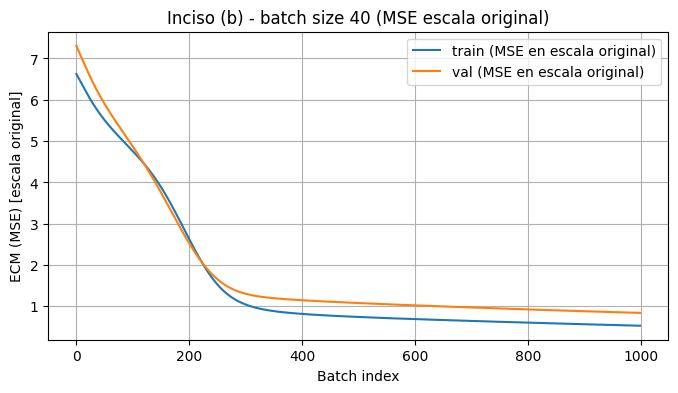

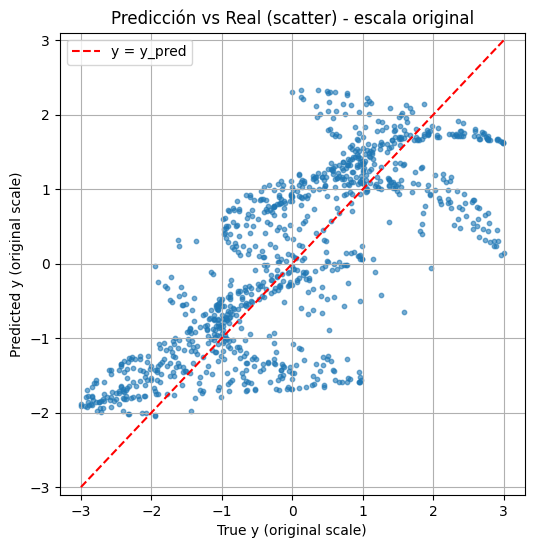

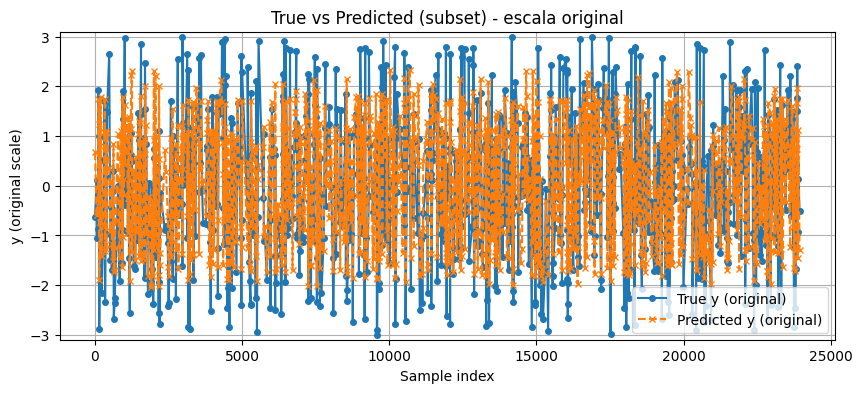

MSE (original scale) para b1 - train (subset 40): 0.530199, test: 0.840762
Tiempo experimento b2 (batch=1): 1464.66s
Len train history b2: 40000 Len val history b2: 1000


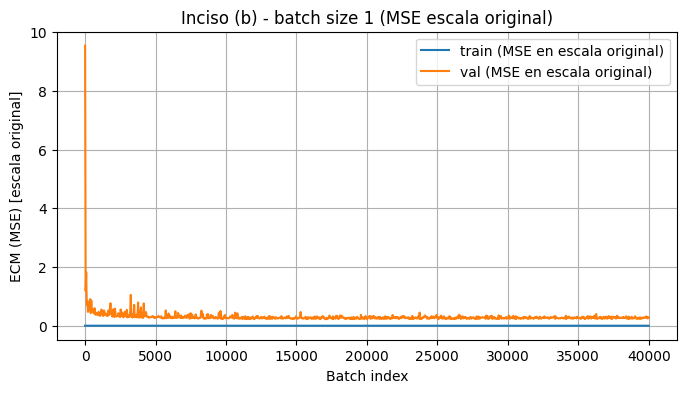

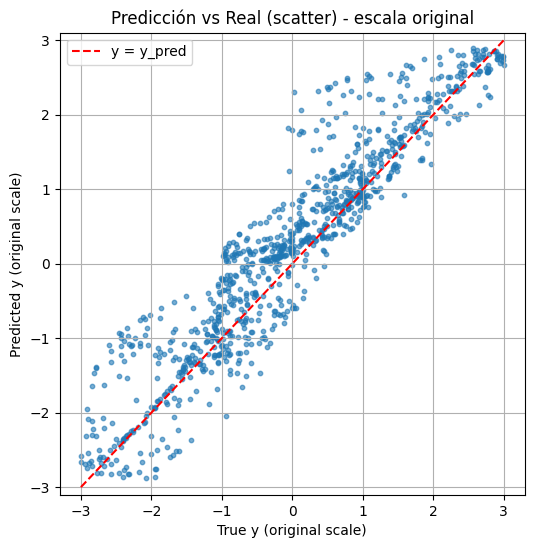

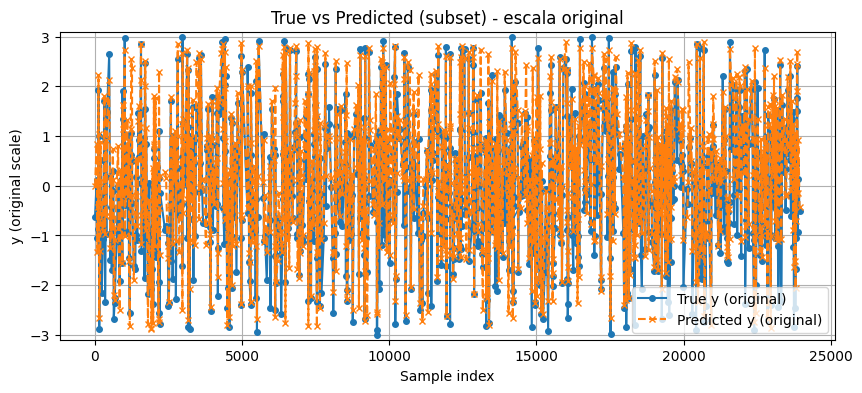

MSE (original scale) para b2 - train (subset 40): 0.010622, test: 0.286971

Resumen comparativo (MSE en escala original):
  batch=40 -> train(subset40)=0.530199, test=0.840762
  batch=1  -> train(subset40)=0.010622, test=0.286971

Observaciones:
- Con batch=40 (entrenamiento por batches del tamaño del dataset pequeño) suele converger de forma más estable pero puede sobreajustar si damos muchas pasadas.
- Con batch=1 (estocástico) la trayectoria del error es más ruidosa; puede generalizar distinto según la tasa de aprendizaje y la cantidad de pasos.


In [22]:

# ---- Inciso (b): usar solo 40 muestras de entrenamiento y comparar minibatch sizes ----
print('\n--- Inciso (b): comparar minibatch size = 40 vs = 1 (con solo 40 muestras de entrenamiento) ---')
# seleccionar 40 muestras aleatorias del conjunto de entrenamiento escalado
n_small = 40
N_train = X_train_arr.shape[0]
idx_small = rng.choice(N_train, size=n_small, replace=False)
X_small = X_train_arr[idx_small]
y_small = y_train_arr[idx_small]

# Mostrar algunos valores reales (desescalados) para verificar rango
print('Algunas Y (original scale) del subset de 40:')
print(inverse_scale(y_small[:6].reshape(-1)))

# Experimento 1: minibatch = 40 (batch gradient descent w.r.t dataset_small)
model_b1 = perceptron_multicapa(capas=[30,1], dim_entrada=3)
start = time.time()
# usamos muchas pasadas para ver sobreajuste/variación, entrenar con epochs=1 por minibatch
hist_b1 = model_b1.minibatch_training(X_small, y_small, tamanio=40, veces=1000, lr=0.1, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=20, verbose=False)
print(f'Tiempo experimento b1 (batch=40): {time.time()-start:.2f}s')
print('Len train history b1:', len(hist_b1['train']), 'Len val history b1:', len(hist_b1['val']))

# Graficar
plot_train_val(hist_b1, 'Inciso (b) - batch size 40 (MSE escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_b1, n_samples=1000)

# Evaluación numérica final (MSE en escala original)
def mse_original(model, X, y_scaled):
    preds = model.predecir(np.asarray(X)).reshape(-1)
    preds_orig = inverse_scale(preds)
    y_orig = inverse_scale(np.asarray(y_scaled).reshape(-1))
    return float(np.mean((preds_orig - y_orig)**2))

mse_b1_train = mse_original(model_b1, X_small, y_small)
mse_b1_test = mse_original(model_b1, X_test_arr, y_test_arr)
print(f'MSE (original scale) para b1 - train (subset 40): {mse_b1_train:.6f}, test: {mse_b1_test:.6f}')

# Experimento 2: minibatch = 1 (stochastic)
model_b2 = perceptron_multicapa(capas=[30,1], dim_entrada=3)
start = time.time()
hist_b2 = model_b2.minibatch_training(X_small, y_small, tamanio=1, veces=1000, lr=0.1, epochs=1500, X_val=X_test_arr, Y_val=y_test_arr, eval_every=200, verbose=False)
print(f'Tiempo experimento b2 (batch=1): {time.time()-start:.2f}s')
print('Len train history b2:', len(hist_b2['train']), 'Len val history b2:', len(hist_b2['val']))

plot_train_val(hist_b2, 'Inciso (b) - batch size 1 (MSE escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_b2, n_samples=1000)

mse_b2_train = mse_original(model_b2, X_small, y_small)
mse_b2_test = mse_original(model_b2, X_test_arr, y_test_arr)
print(f'MSE (original scale) para b2 - train (subset 40): {mse_b2_train:.6f}, test: {mse_b2_test:.6f}')

# Resumen comparativo
print('\nResumen comparativo (MSE en escala original):')
print(f'  batch=40 -> train(subset40)={mse_b1_train:.6f}, test={mse_b1_test:.6f}')
print(f'  batch=1  -> train(subset40)={mse_b2_train:.6f}, test={mse_b2_test:.6f}')

print('\nObservaciones:')
print('- Con batch=40 (entrenamiento por batches del tamaño del dataset pequeño) suele converger de forma más estable pero puede sobreajustar si damos muchas pasadas.')
print('- Con batch=1 (estocástico) la trayectoria del error es más ruidosa; puede generalizar distinto según la tasa de aprendizaje y la cantidad de pasos.')

# Fin de celda de experimentos


--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---
pass 1/10 batch 1/560 train_loss=0.262236 val_loss=0.281123
pass 1/10 batch 57/560 train_loss=0.062286
pass 1/10 batch 113/560 train_loss=0.031278
pass 1/10 batch 169/560 train_loss=0.022445
pass 1/10 batch 225/560 train_loss=0.016838
pass 1/10 batch 281/560 train_loss=0.017030
pass 1/10 batch 337/560 train_loss=0.013839
pass 1/10 batch 393/560 train_loss=0.015063
pass 1/10 batch 449/560 train_loss=0.011881
pass 1/10 batch 505/560 train_loss=0.014379
pass 2/10 batch 1/560 train_loss=0.012684 val_loss=0.012437
pass 2/10 batch 57/560 train_loss=0.014123
pass 2/10 batch 113/560 train_loss=0.012887
pass 2/10 batch 169/560 train_loss=0.011556
pass 2/10 batch 225/560 train_loss=0.009985
pass 2/10 batch 281/560 train_loss=0.011548
pass 2/10 batch 337/560 train_loss=0.009693
pass 2/10 batch 393/560 train_loss=0.008806
pass 2/10 batch 449/560 train_loss=0.007732
pass 2/10 batch 505/560 train_loss=0.010032
pass 3/10 batch 1/560 train

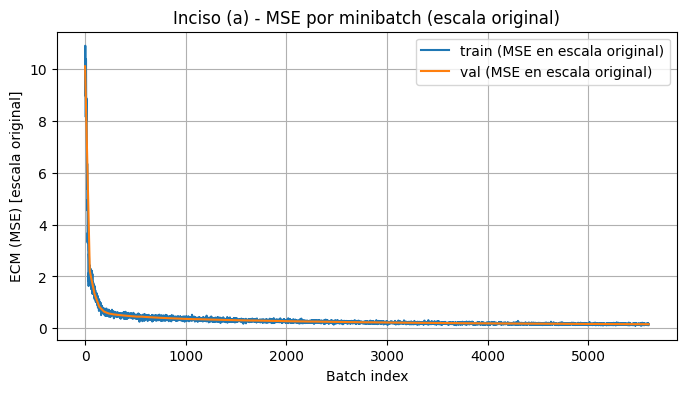

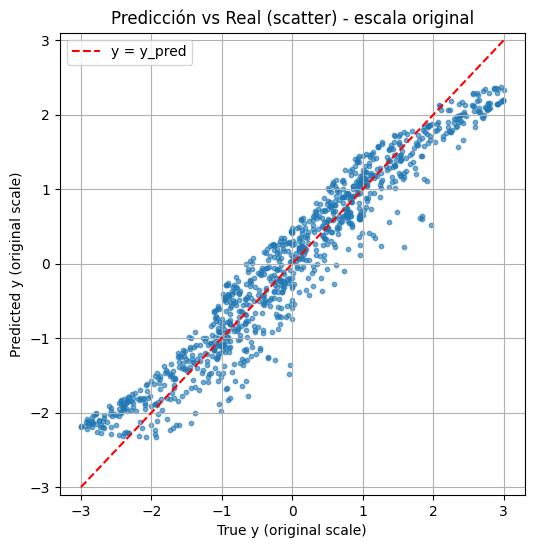

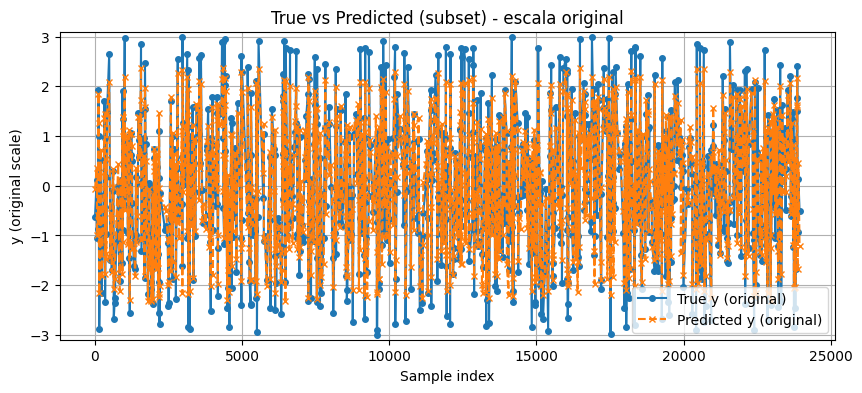


Ejemplo:
Entrada (x,y,z): [0.5, 1.0, -1]
Predicción (escala original): 0.196217
Valor real (escala original): 0.019728

--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---
pass 1/10 batch 1/56 train_loss=0.266474 val_loss=0.253832


C:\Users\q\AppData\Local\Temp\ipykernel_17892\3400245446.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_orig = float(inverse_scale(pred_scaled))


pass 1/10 batch 6/56 train_loss=0.245277
pass 1/10 batch 11/56 train_loss=0.236867
pass 1/10 batch 16/56 train_loss=0.196438
pass 1/10 batch 21/56 train_loss=0.157798
pass 1/10 batch 26/56 train_loss=0.117573
pass 1/10 batch 31/56 train_loss=0.080323
pass 1/10 batch 36/56 train_loss=0.060474
pass 1/10 batch 41/56 train_loss=0.052265
pass 1/10 batch 46/56 train_loss=0.050387
pass 1/10 batch 51/56 train_loss=0.045468 val_loss=0.045731
pass 1/10 batch 56/56 train_loss=0.042618
pass 2/10 batch 1/56 train_loss=0.044135 val_loss=0.042979
pass 2/10 batch 6/56 train_loss=0.042894
pass 2/10 batch 11/56 train_loss=0.037584
pass 2/10 batch 16/56 train_loss=0.035747
pass 2/10 batch 21/56 train_loss=0.039322
pass 2/10 batch 26/56 train_loss=0.035041
pass 2/10 batch 31/56 train_loss=0.034150
pass 2/10 batch 36/56 train_loss=0.031858
pass 2/10 batch 41/56 train_loss=0.033022
pass 2/10 batch 46/56 train_loss=0.029681
pass 2/10 batch 51/56 train_loss=0.029997 val_loss=0.030622
pass 2/10 batch 56/56 tra

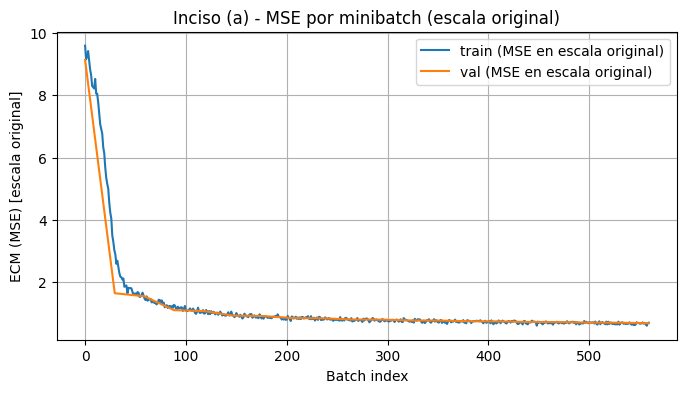

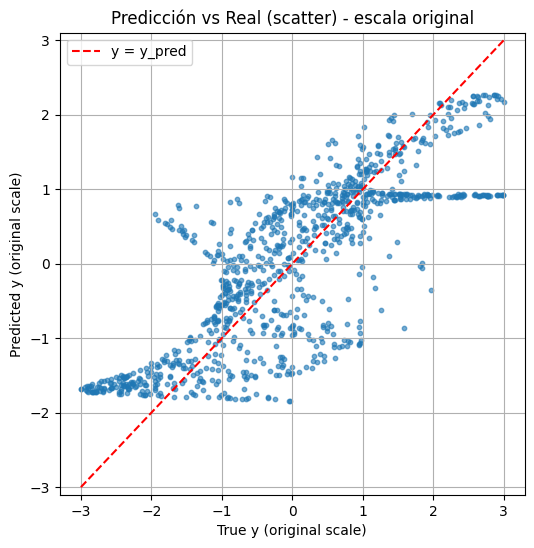

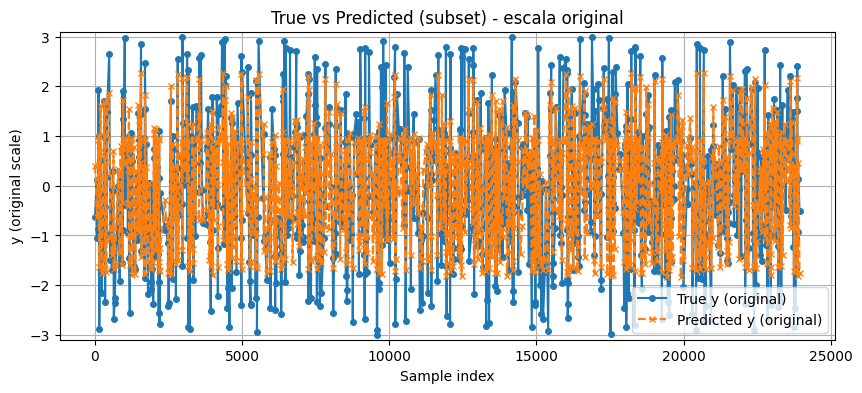


Ejemplo:
Entrada (x,y,z): [0.5, 1.0, -1]
Predicción (escala original): -0.442453
Valor real (escala original): 0.019728


-0.4424531931215059

In [8]:
# === Experimentos: Inciso (a) y (b) ===
# - (a) Entrenar en el dataset completo y mostrar evolución de error y predicciones
# - (b) Tomar un conjunto de entrenamiento con 40 muestras y comparar minibatch size = 40 vs = 1

import time

# Comprobaciones básicas
try:
    X_train_arr
    y_train_arr
    X_test_arr
    y_test_arr
except NameError:
    raise NameError('Ejecutá antes las celdas que generan y escalan X_train_arr / y_train_arr / X_test_arr / y_test_arr')

rng = np.random.default_rng(42)

# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[10,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=100, veces=10, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)


# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[10,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=1000, veces=10, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)


